# Intrinsic/Extrinsic Parameter estimation

- 학번 : 20233142
- 이름 : 박정은

---

OpenCV를 사용해 여러 장의 체스 보드 이미지에 대한 카메라의 내부/외부 파라미터를 구한다.

---

**[중요] 과제 제출 방법**
- 과제 제출 기한은 가상대학 공지사항을 참고하세요.
- 과제는 Colab에서 작성한 것을 다운받아 (파일 > 다운로드 > .ipynb 다운로드) 가상 대학에 업로드합니다. (이외의 제출 방법은 인정하지 않음)
- 제출 시 파일 제목은 '학번_이름' 으로 저장합니다.

In [76]:
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

print('python', sys.version)
print('numpy', np.__version__)
print('opencv', cv.__version__)

python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy 1.25.2
opencv 4.8.0


## Google Drive와 연동하기


In [2]:
# mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/My Drive/Colab Notebooks/Vehicle Intelligence/img/calib/'

left01.jpg  left03.jpg	left05.jpg  left07.jpg	left09.jpg  left12.jpg	left14.jpg
left02.jpg  left04.jpg	left06.jpg  left08.jpg	left11.jpg  left13.jpg	pattern.png


In [4]:
ROOT = '/content/drive/My Drive/Colab Notebooks/Vehicle Intelligence/img/calib/'

### 이미지 불러오기

좋은 결과를 위해 최소 10장의 사진이 준비되어야 한다.

13


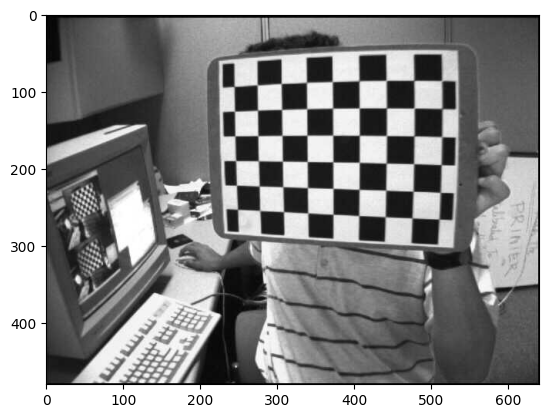

In [28]:
images = []
image_files = glob.glob(ROOT + '*.jpg')
for f in image_files :
  img = cv.imread(f)
  images.append(img)

print(len(images))
plt.imshow(images[0][:,:,::-1])

## 체스 보드 코너 찾기




관련 함수

- `	retval, corners	=	cv.findChessboardCorners(	image, patternSize[, corners[, flags]]	)`
- `corners	=	cv.cornerSubPix(	image, corners, winSize, zeroZone, criteria`
- `	image	=	cv.drawChessboardCorners(	image, patternSize, corners, patternWasFound	)`



**과제**

- 관련 함수들에 대한 입력과 출력, 파라미터를 조사해 서술한다.
- 관련 함수들을 사용하여 체스 보드의 코너를 찾는 함수 `findCorner()`를 완성한다. `findCorner()` 함수의 입력과 출력은 다음과 같다.
  - 입력 : 코너를 찾을 체스 보드의 이미지
  - 출력
    - ret : 함수의 성공 여부
    - corner_refine : `cv.cornerSubPix()`를 통해 개선된 코너점
    - corner_img : 찾은 코너와 원본 이미지를 합성한 이미지


**참고**

- 주어진 체스 보드는 9x6 grid이다.




In [29]:
w = 6
h = 9

# Prepare object points, like(0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
xval, yval = np.arange(h), np.arange(w) #너비와 높이 방향으로 범위를 나타내는 배열 만들기
objp = np.meshgrid(xval, yval, 0.) #objp배열을 0으로 초기화하기
objp = np.concatenate(objp, axis=2) #두번째 축을 기준으로 결합
objp = objp.reshape(-1,3) #배열을 (n, 3)형태로 변환하기.
objp = objp.astype(np.float32) #배열을 float32로 변환


In [30]:
def findCorner(img) :
  # To-do
  size = (h, w)
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
  # 각 체커보드 이미지에 대한 3D 점 벡터를 저장할 벡터 생성
  # cv.TERM_CRITERIA_EPS: 원하는 정확도에 도달했을 때 알고리즘이 멈춤
  # cv.TERM_CRITERIA_MAX_ITER: 설정된 최대 반복 횟수에 도달했을 때 알고리즘이 멈춤

  ret, corners = cv.findChessboardCorners(gray,  size, None)
  #patternSize = 체스보드의 내부 코너의 개수를 나타내는 튜플, 체스보드가 6*9의 코너를 가지고 있으면 (6, 9)로 지정하기
  #corners = 코너의 초기 위치(감지된 코너의 출력 배열)
  #flags = 작업 플래그, 조합해서 쓸 수도 있다.

  corner_refine = cv.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria) # 주어진 2D 점에 대한 픽셀 좌표 미세조정
  # corners = cv.findChessboardCorners 함수로부터 얻은 코너 위치
  # (11, 11)는 11x11 픽셀의 크기를 가진 검색 윈도우를 의미
  # (-1, -1)는 이웃코너들과의 영향 범위를 줄이지 않겠다는 의미
  # criteria = 종료 기준. 알고리즘이 언제 멈출지를 결정하는 조건

  corner_img = cv.drawChessboardCorners(img,  size, corner_refine, ret) # 코너 그리기 및 표시
  # corner_refine = cv.cornerSubPix 함수로 더 정밀하게 조정된 코너 위치의 배열
  # ret = 코너 검출 성공 여부를 나타내는 bool값

  return ret, corner_refine, corner_img


#Calibration pattern(캘리브레이션 패턴): 이미징 프로세스를 제어할 수 있는 경우, 여러 관점에서 알려진 차원패턴의 여러 이미지를 캡쳐함.
#3D 점 (X_w, Y_w, Z_w)와 해당 이미지 좌표 (u, v) 세트를 사용하여 3×3 행렬 K, 3×3 회전 행렬 R, 3×1 이동 벡터 t를 찾는 것이 목표

#외부 파라미터(extrinsic parameters: Rotation R과 translation t)를 사용하여 점을 세계 좌표계에서 카메라 좌표계로 변환
#내부 파라미터(intrinsic parameters)를 사용하여 점을 이미지 평면에 투영

#findChessBoradCorners: 체커보드를 찾고 코너 좌표를 반환하는 cv의 내장함수
#+flags옵션 추가설명:
#cv.CALIB_CB_ADAPTIVE_THRESH: 적응형 임계값을 사용하여 이진화. 조명이 균일하지 않은 경우에 사용
#cv.CALIB_CB_NORMALIZE_IMAGE: 이진화하기 전에 이미지를 정규화. 이미지를 균일하게 만들기 위해 사용
#cv.CALIB_CB_FILTER_QUADS: 쿼드 검출을 향상시킴. 체스보드의 쿼드가 왜곡되거나 부분적으로 보일 때 사용
#cv.CALIB_CB_FAST_CHECK: 더 빠른 Check를 수행하여 체스보드가 있는지 없는지 빠르게 결정. 체스보드가 없을 가능성이 높을 때 시간 절약을 위해 사용


#참고: https://foss4g.tistory.com/1665
#참고: https://moon-coco.tistory.com/entry/OpenCVCamera-Calibration%EC%B9%B4%EB%A9%94%EB%9D%BC-%EC%99%9C%EA%B3%A1-%ED%8E%B4%EA%B8%B0

In [31]:
# 이 부분은 수정하지 않습니다.

objpoints = [] # 실제 세계의 3D 포인트들
imgpoints = [] # 이미지 평면 상의 2D 포인트들
corner_imgs = [] # 이미지 합성 결과를 저장

for img in images :

  ret, corner, corner_img = findCorner(img)

  if ret == True :
    objpoints.append(objp)
    imgpoints.append(corner)
    corner_imgs.append(corner_img)


### 찾은 코너 시각화

13


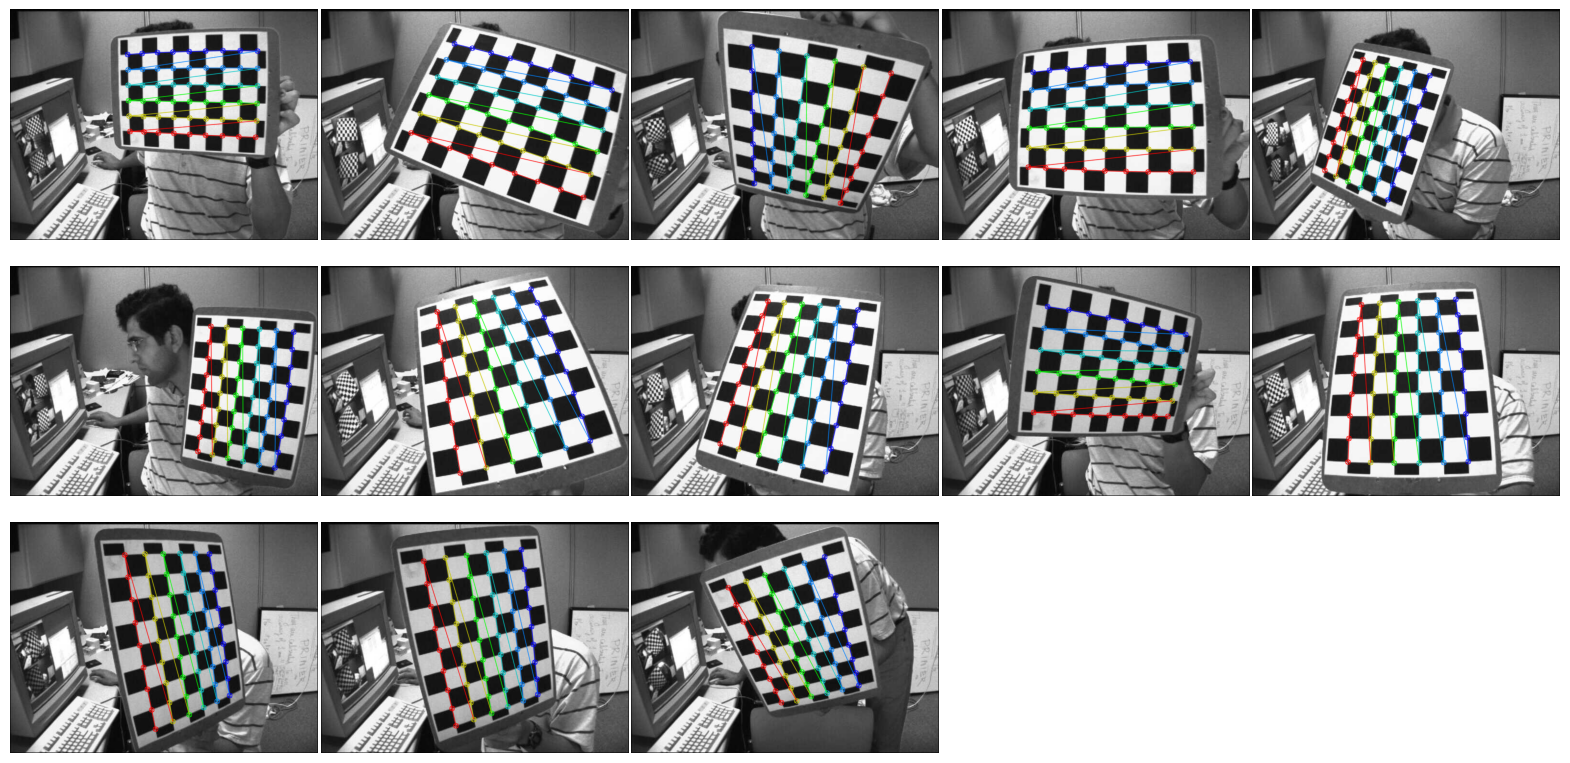

In [32]:
# 이 부분은 수정하지 않습니다.

from matplotlib.gridspec import  GridSpec
print(len(corner_imgs))

nrows = 3
ncols = 5

fig = plt.figure(figsize = (20,10))
grid = GridSpec(nrows, ncols, wspace=0.01, hspace=0.0)

for i, img in enumerate(corner_imgs) :
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(img)

## Calibration

찾은 코너 포인트를 이용해 카메라의 내부/외부 파라미터를 찾는다.

**과제**

- 카메라 매트릭스와 회전/이동 벡터들을 구한다.

관련 함수

- `cv.calibrateCamera`

In [33]:
# To-do : cam_matrix, rotation_vectors, translation_vectors를 찾기
# 그레이스케일로 변환된 첫 번째 이미지의 크기 가져오기
gray = cv.cvtColor(images[0], cv.COLOR_BGR2GRAY)
ret, cam_matrix, dist, rotation_vectors, translation_vectors = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# objpoints: 3D 공간에서의 객체의 포인트를 나타내는 리스트. 여러 이미지에서 동일한 객체의 3D 좌표를 포함함
# imgpoints: 이미지 평면에서 검출된 객체의 포인트를 나타내는 리스트

# cam_matrix: 카메라의 내부 파라미터를 나타냄. 초점 거리, 광학 중심 및 왜곡 등등
# rotation_vectors: 이미지 평면에서의 회전 벡터
# translation_vectors: 이미지 평면에서의 번역 벡터

In [34]:
# 이 부분은 수정하지 않습니다.

print('camera matrix \n', cam_matrix)
print('rotation vectors \n', rotation_vectors)
print('translation vectors \n', translation_vectors)

camera matrix 
 [[536.07343019   0.         342.37038791]
 [  0.         536.01634475 235.53685635]
 [  0.           0.           1.        ]]
rotation vectors 
 (array([[0.16853568],
       [0.27575314],
       [0.01346807]]), array([[-0.27697519],
       [ 0.186891  ],
       [ 0.35483188]]), array([[ 0.41306755],
       [ 0.64934521],
       [-1.3371948 ]]), array([[-0.11082302],
       [ 0.23974769],
       [-0.0021351 ]]), array([[0.1794729 ],
       [0.34574756],
       [1.86847037]]), array([[0.40772934],
       [0.30384783],
       [1.64906546]]), array([[-0.29188239],
       [ 0.42829931],
       [ 1.31269863]]), array([[-0.09096653],
       [ 0.47965894],
       [ 1.75338411]]), array([[ 0.20290377],
       [-0.42414174],
       [ 0.13245569]]), array([[-0.23849916],
       [ 0.3477755 ],
       [ 1.53073677]]), array([[-0.41926863],
       [-0.49992931],
       [ 1.33554713]]), array([[-0.17020413],
       [-0.47139603],
       [ 1.34598619]]), array([[ 0.46301586],
       [

**과제**

- 아래 링크를 참고하여 얻어낸 camera matrix, rotation and translation vector를 이용해 이미지 상에 3D 축을 그린다.
- https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html

In [35]:
def draw(img, corners, imgpts):
    #corners배열에서 ravel함수를 사용해 평탄화한 후 tuple변환
    #    -> corner는 첫번쨰 코너 점의 x, y좌표를 갖게됨
    corner = tuple(map(int, corners[0].ravel()))
    #corne 점에서 imgpts의 첫 번째 점까지 파란색 선 그리기
    img = cv.line(img, corner, (int(imgpts[0,0,0]), int(imgpts[0,0,1])), (255,0,0), 5)
    #corner점에서 imgpts의 두 번째 점까지 녹색 선 그리기
    img = cv.line(img, corner, (int(imgpts[1,0,0]), int(imgpts[1,0,1])), (0,255,0), 5)
    #corner점에서 imgpts의 세 번째 점까지 빨간색 선 그리기
    img = cv.line(img, corner, (int(imgpts[2,0,0]), int(imgpts[2,0,1])), (0,0,255), 5)
    return img

In [38]:
axis = np.float32([[3, 0, 0], [0, 3, 0], [0, 0, -3]]).reshape(-1, 3)
axis_imgs = []

for i, img in enumerate(images):
  #cv.projectPoints 함수는 3D 포인트(axis)를 2D 이미지 포인트로 투영함.
    imgpts, jac = cv.projectPoints(axis, rotation_vectors[i], translation_vectors[i], cam_matrix, dist)
#draw 함수는 img에 3D 축을 그리는 역할
#imgpoints[i]: 이미지의 코너 점
#imgpts: 투영된 2D 이미지 점들
    img_draw = draw(img, imgpoints[i], imgpts)
    axis_imgs.append(img_draw)

13


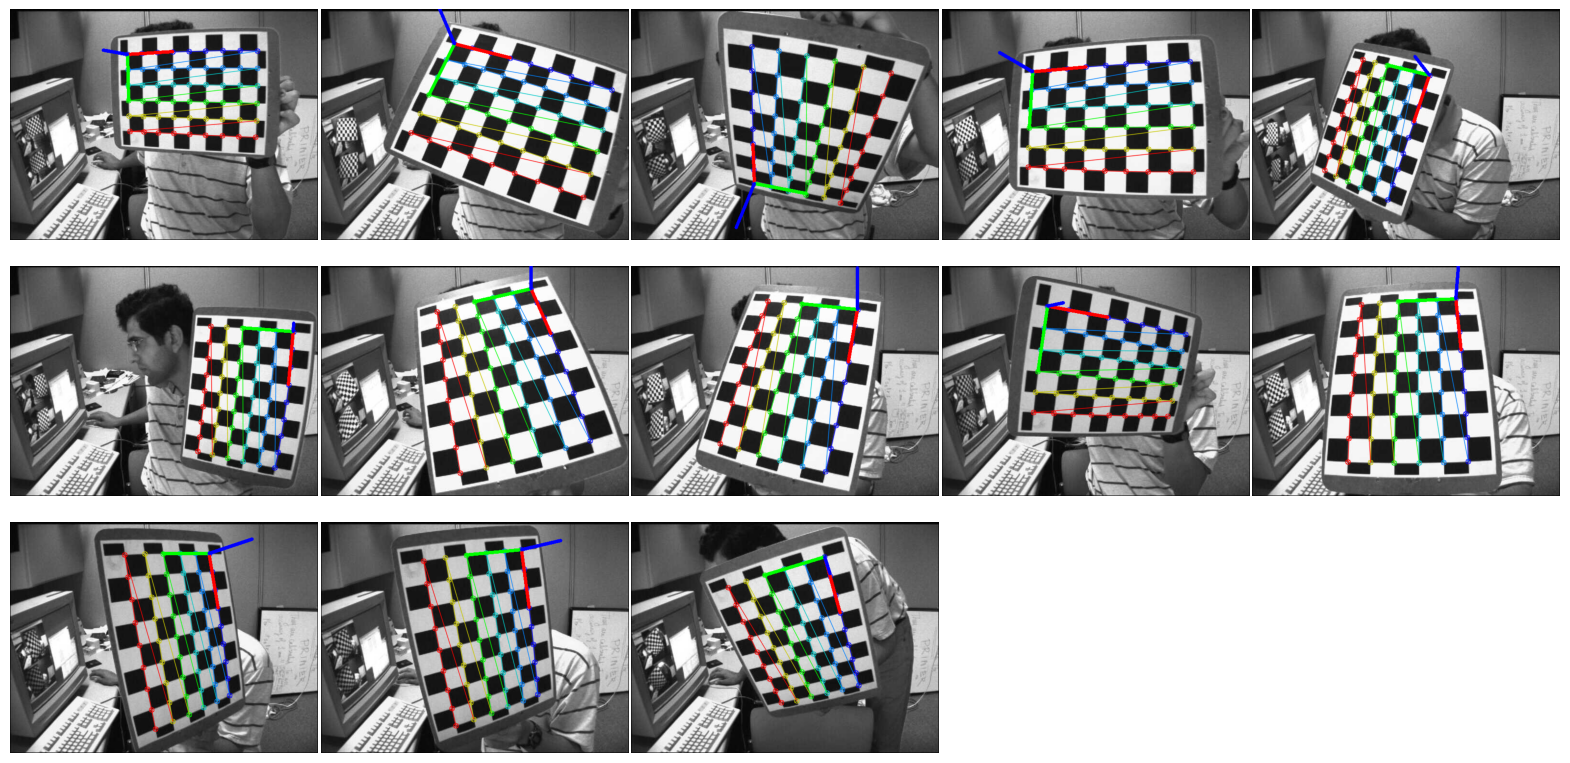

In [39]:
from matplotlib.gridspec import  GridSpec
print(len(axis_imgs))

nrows = 3
ncols = 5

fig = plt.figure(figsize = (20,10))
grid = GridSpec(nrows, ncols, wspace=0.01, hspace=0.0)

for i, img in enumerate(axis_imgs) :
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(img)

## 추가 점수 과제

직접 찍은 체스 보드 이미지를 사용해 위 과정을 똑같이 수행한다.
  - 체스 보드는 첨부된 이미지(pattern.png), 직접 그린/다운로드한 이미지 등을 출력해 사용한다.

In [81]:
img = cv.imread(ROOT+ 'pattern.png')

In [82]:
xval, yval = np.arange(h), np.arange(w)
objp = np.meshgrid(xval, yval, 0)
objp = np.concatenate(objp, axis=2)
objp = objp.reshape(-1, 3)
objp = objp.astype(np.float32)

In [83]:
ret, corners, corner_img = findCorner(img)

objpoints = []
imgpoints = []
corner_imgs = []

if ret:
  objpoints.append(objp)
  imgpoints.append(corners)
  corner_imgs.append(corner_img)

In [59]:
gray = cv.cvtColor(images[0], cv.COLOR_BGR2GRAY)
ret, cam_matrix, dist, rotation_vectors, translation_vectors = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [60]:
axis = np.float32([[3, 0, 0], [0, 3, 0], [0, 0, -3]])
imgpts, jac = cv.projectPoints(axis, rotation_vectors[0], translation_vectors[0], cam_matrix, dist)
img_draw = draw(img, imgpoints[0], imgpts)

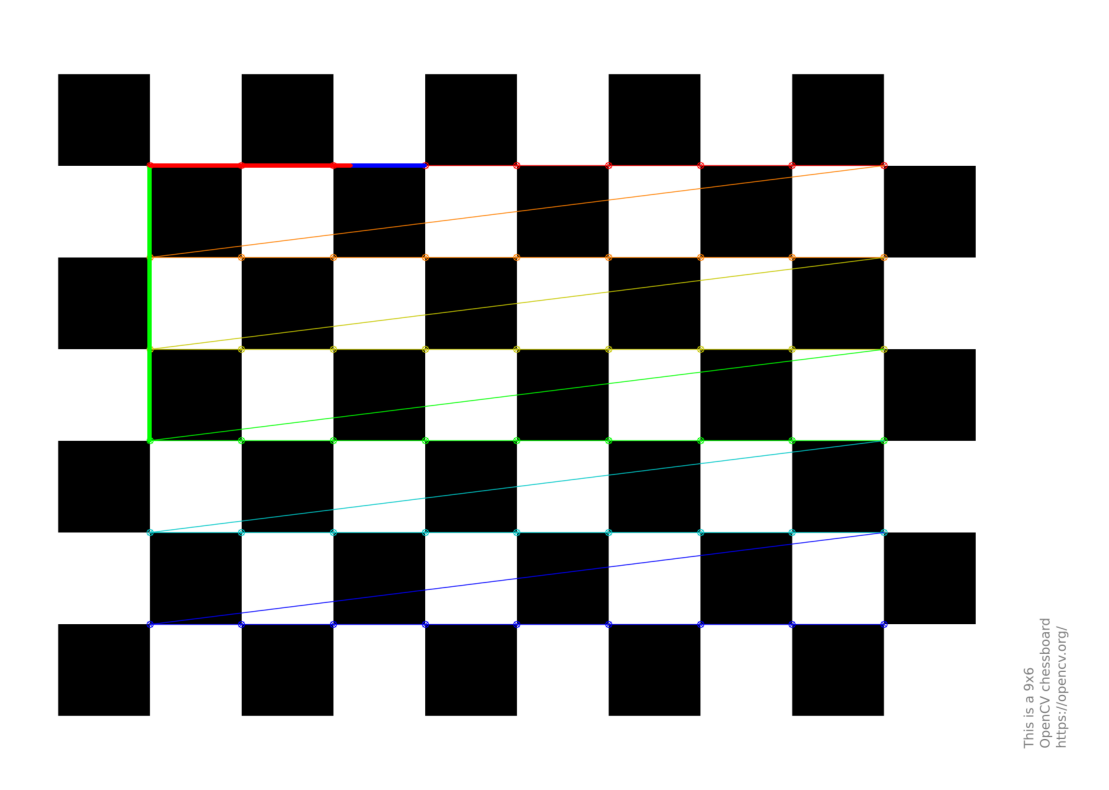

In [61]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
ax.imshow(cv.cvtColor(img_draw, cv.COLOR_BGR2RGB))
plt.show()